## 文档聚类与主题提取

本文主要介绍使用K-means算法对文档进行聚类，并且使用LDA模型提取每个聚类中的关键词。使用的语料是`历史`的文档集合  
本文的代码和使用的数据可以在[github](https://github.com/snowhyzhang/yukino/tree/master/nlp)上找到

### 语料预处理

获取语料路径

In [1]:
import glob

doc_files = glob.glob('data/C7-History/*.txt')
doc_files[:5]

['data/C7-History/C7-History001.txt',
 'data/C7-History/C7-History002.txt',
 'data/C7-History/C7-History004.txt',
 'data/C7-History/C7-History006.txt',
 'data/C7-History/C7-History008.txt']

读入文档

In [2]:
documents = []

for file in doc_files:
    with open(file, encoding='GB18030') as f:
        documents.append(f.read())
len(documents)

454

配置分词器，这里加入了一些自定义的参数

In [3]:
import re
import jieba
import jieba.posseg as pseg

# 读入停用词
stopwords = set()
with open('dict/stopwords.utf8.txt') as f:
    for word in f.readlines():
        word = word.strip()
        stopwords.add(word)

# 配置目标词性，只保留名词和动词
def require_tag_func(tag):
    return re.search(r'^n.*|^v.*', tag)

# 只保留中文
def post_word_process_func(word):
    word = re.sub(r'[^\u4e00-\u9fa5]', '', word)
    return word.strip()

class ChineseTokenizer():
    def __init__(self, stopwords=None, post_word_process_func=None, require_tag_func=None, min_length=1):
        """
        配置分词器
        
        :param stopwords: 停用词
        :param post_word_process_func: 后处理词函数
        :param require_tag_func: 配置符合要求词性的函数
        :param min_length: 词语最小长度
        """
        self.stopwords = stopwords
        self.post_word_process_func = post_word_process_func
        self.require_tag_func = require_tag_func
        self.min_length = min_length
    
    def post_process_word(self, word_tag):
        word, tag = word_tag
        word = word.strip()
        if self.post_word_process_func:
            word = post_word_process_func(word)
        return (word, tag)
    
    def is_valid_word(self, word_tag):
        word, tag = word_tag
        if len(word) < self.min_length:
            return False
        if self.stopwords and word in self.stopwords:
            return False
        if self.require_tag_func and not self.require_tag_func(tag):
            return False
        return True
    
    def tokenize(self, s):
        words = pseg.cut(s)
        words = map(lambda x: self.post_process_word(x), words)
        words = filter(lambda x: self.is_valid_word(x), words)
        words = [word for word, _ in words]
        return words
    
    def __call__(self, doc):
        return self.tokenize(doc)

chn_tokenizer = ChineseTokenizer(stopwords=stopwords, 
                                 post_word_process_func=post_word_process_func, 
                                 require_tag_func=require_tag_func, 
                                 # 最小词长度设置为2
                                 min_length=2)

对语料进行分词，建立document-term矩阵

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(tokenizer=chn_tokenizer, lowercase=False, 
                             min_df=3, max_df=0.8, max_features=2000)

X = count_vect.fit_transform(documents)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/24/5z49fxqn0zx_9ymk936f_9t00000gn/T/jieba.cache
Loading model cost 0.934 seconds.
Prefix dict has been built succesfully.


`TF-IDF`转换

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(norm='l2')
X_tfidf = tfidf_transformer.fit_transform(X)

### 文档聚类

使用`k-means`聚类算法，尝试20个聚类结果，并通过观察`内聚度`来选定聚类个数

In [6]:
from sklearn.cluster import KMeans

cluster_range = range(1, 20)
inertia_list = []
for i in cluster_range:
    km = KMeans(n_clusters=i, init='k-means++', random_state=1024, n_jobs=-1)
    km.fit(X_tfidf)
    inertia_list.append(km.inertia_)

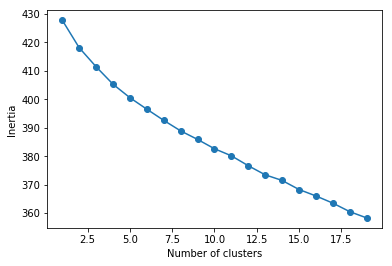

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(cluster_range, inertia_list, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

从`内聚度`趋势图上来看，并不能找到明显的_拐点_，可能比较难以选定个数。这里选定K为8，将文本分为8个聚类

In [8]:
import numpy as np

km = KMeans(n_clusters=8, init='k-means++', random_state=1024, n_jobs=-1)
y_km = km.fit_predict(X)

cl, num = np.unique(y_km, return_counts=True)
cluster_size = dict(zip(cl, num))
cluster_size

{0: 7, 1: 53, 2: 352, 3: 25, 4: 3, 5: 1, 6: 10, 7: 3}

### 提取主题

提取相应文档聚类中的语料

In [9]:
from gensim import corpora
from gensim.matutils import Sparse2Corpus

def get_corpus_dictionary(X, cluster_index, cluster_num, count_vect):
    index = np.where(cluster_index == cluster_num)
    X_cluster = X[index[0], :]
    corpus = Sparse2Corpus(X_cluster, documents_columns=False)
    dictionary = corpora.Dictionary.from_corpus(corpus, id2word=dict((id, word) for word, id 
                                                                     in count_vect.vocabulary_.items()))
    return corpus, dictionary
    

In [10]:
from gensim import models

cor_dict = []
for cluster_num in np.unique(y_km):
    corpus, dictionary = get_corpus_dictionary(X, y_km, cluster_num, count_vect)
    cor_dict.append((corpus, dictionary))

训练LDA模型

In [11]:
from gensim import models

lda_models = []
for corpus, dictionary in cor_dict:
    lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=1, iterations=50, random_state=1024)
    lda_models.append(lda_model)

提取主题词

In [12]:
for cluster_num, lda_model in enumerate(lda_models):
    topics = [word for word, _ in lda_model.show_topics(num_words=8, formatted=False)[0][1]]
    size = cluster_size[cluster_num]
    print('cluster@%d size@%d topic@%s' % (cluster_num + 1, size, topics))

cluster@1 size@7 topic@['音乐', '文化', '戏剧', '乐器', '历史剧', '艺术', '表演', '时代']
cluster@2 size@53 topic@['文化', '史学', '理论', '问题', '传统', '思想', '方法', '民族']
cluster@3 size@352 topic@['问题', '经济', '政治', '文化', '时期', '革命', '国家', '民族']
cluster@4 size@25 topic@['美国', '世界', '国家', '经济', '资本主义', '民族', '战争', '政治']
cluster@5 size@3 topic@['语言', '理论', '语法', '结构', '混合', '语义', '汉语', '语言学']
cluster@6 size@1 topic@['平面', '语法', '语义', '结构', '句法', '句子', '意义', '形式']
cluster@7 size@10 topic@['小说', '创作', '艺术', '作品', '文学', '作家', '文化', '表现']
cluster@8 size@3 topic@['鲁迅', '思想', '文化', '鲁迅研究', '政治', '革命', '知识分子', '作品']
